# INTRODUÇÃO

- **myhome.com**: `O produto principal da empresa é uma plataforma de compra e venda de imóveis com curadoria automatizada por Machine Learning` que se adapta ao que tanto os vendedores quanto compradores procuram. A empresa é focada em imóveis para fins residenciais e o público em outros países gira em torno de pessoas que estão adquirindo o primeiro imóvel próprio.  A empresa está se preparando para entrar no mercado brasileiro, a começar pela cidade de São Paulo. A `myhome.com ainda está entendendo o ambiente do mercado brasileiro` e não tem especialistas no assunto quando se trata do Brasil ou da cidade de São Paulo.



## Infos & Objetivos

gostaríamos de entender melhor o cenário do mercado na cidade. 
- Qual o perfil dos imóveis disponíveis para venda?
- Onde seria o lugar ideal para começar a prospectar clientes? 
- `Uma das coisas que queriamos entender é se há maior disponibilidade de imoveis em regioes da zona sul da cidade comparado com outras regioes? Se regioes mais afastadas do centro Possuem maior disponibilidade ou nao`
  
O time de Engenharia de Dados disponibilizou um conjunto de dados no Data Lake da empresa que contém um `dump` de listings do mercado imobiliário de São Paulo proveniente de várias fontes.

**Contact with business**
- Tem algo além dessas duas questões que vocÊs queiram validar?
- é possível disponibilizar o dump em algum outro ambiente?

# IDEIAS E OBSERVAÇÕES

- processamento das colunas `address` e `pricingInfos` da listings_df -> OK;  
- Tenho que fazer uma segunda expansao da coluna `LocationID` que sera criada a partir do `address`; 
- Fazer uma avaliação individual de colunas possivelmente relevantes;


#INITIALIZING

In [1]:
db_path = '/content/drive/MyDrive/0_Machine_Learning/Projetos/Myhome.com/listings_dump.json'

#LIBS

In [2]:
import pandas as pd
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# CHECKING THE DATASET

In [4]:
# From version 0.19.0 of Pandas you can use the `lines` parameter,
# Otherwise it rises a `Trailing Error`
listings_df = pd.read_json(db_path, lines=True)

In [5]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133964 entries, 0 to 133963
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   usableAreas      133211 non-null  float64
 1   description      133964 non-null  object 
 2   title            133964 non-null  object 
 3   createdAt        133964 non-null  object 
 4   publisherId      133964 non-null  object 
 5   unitTypes        133964 non-null  object 
 6   listingStatus    133964 non-null  object 
 7   id               133964 non-null  object 
 8   parkingSpaces    129539 non-null  float64
 9   updatedAt        127367 non-null  object 
 10  owner            133964 non-null  bool   
 11  images           133964 non-null  object 
 12  address          133964 non-null  object 
 13  suites           120347 non-null  float64
 14  publicationType  133964 non-null  object 
 15  bathrooms        133051 non-null  float64
 16  totalAreas       91132 non-null   floa

In [6]:
listings_df.head()

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos
0,388.0,"04 dorms sendo 01 suíte e closet, sala de esta...",PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,2017-02-07T13:21:40Z,f4603b2b52,TWO_STORY_HOUSE,ACTIVE,787c7bd19d,6.0,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04290030', 'city...",1.0,STANDARD,3.0,388.0,4.0,"{'price': 700000, 'businessType': 'SALE'}"
1,129.0,"03 dorms sendo 01 suíte, sala, sala de jantar,...",PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,2016-03-21T18:35:17Z,f4603b2b52,HOME,ACTIVE,4d68c0cdbe,2.0,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04187320', 'city...",1.0,STANDARD,2.0,129.0,3.0,"{'price': 336000, 'businessType': 'SALE'}"
2,396.0,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",Excelente Conjunto Comercial na Av. Paulista,2018-12-18T23:47:03.425Z,501f6d5e94,COMMERCIAL_PROPERTY,ACTIVE,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,"{'country': '', 'zipCode': '01311000', 'city':...",0.0,STANDARD,4.0,NaN,0.0,"{'period': 'MONTHLY', 'yearlyIptu': 4040, 'pri..."
3,80.0,"Viva melhor e de um jeito novo, com privilégio...","Apartamento com 80m², 2 vagas próximo ao Parqu...",2018-10-26T16:18:28.915Z,527c7b0cc0,APARTMENT,ACTIVE,6654d93423,2.0,2018-11-08T16:38:35.434Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '04550004', 'city':...",1.0,STANDARD,2.0,80.0,3.0,"{'yearlyIptu': 1610, 'price': 739643, 'busines..."
4,3322.0,Sua área é ocupada majoritariamente por instit...,"Apartamento 332m², 4 suítes à venda próximo ao...",2018-12-14T18:06:51.342Z,527c7b0cc0,APARTMENT,ACTIVE,9ffaf676ae,5.0,2018-12-14T18:06:55.140Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '04005030', 'city':...",4.0,STANDARD,5.0,332.0,4.0,"{'yearlyIptu': 18900, 'price': 7520099, 'busin..."


será necessária um segundo processamento das colunas `address` e `pricingInfos`, para expandir as infos dos dicts

## Expandindo a coluna `address`

### teste para como expandir as features

Primeiro vou fazer um teste de como posso fazer o unpacking dessas infos de forma a criar um dataframe novo com esses atributos

In [7]:
address = listings_df.loc[0,'address']

In [8]:
address

{'city': 'São Paulo',
 'country': 'BR',
 'district': '',
 'geoLocation': {'location': {'lat': -23.612923, 'lon': -46.614222},
  'precision': 'ROOFTOP'},
 'locationId': 'BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da Saude',
 'neighborhood': 'Jardim da Saúde',
 'state': 'São Paulo',
 'street': 'Rua Juvenal Galeno',
 'streetNumber': '53',
 'unitNumber': '',
 'zipCode': '04290030',
 'zone': 'Zona Sul'}

In [9]:
type(address)

dict

In [10]:
address['geoLocation']['precision']

'ROOFTOP'

In [11]:
address['precision'] = address['geoLocation']['precision']

In [12]:
address['geoLocation'] = address['geoLocation']['location']

In [13]:
address['geoLocation'] 

{'lat': -23.612923, 'lon': -46.614222}

In [14]:
a = pd.DataFrame(address)
a.head()

,country,zipCode,city,streetNumber,zone,geoLocation,street,locationId,district,unitNumber,state,neighborhood,precision
lat,BR,04290030,São Paulo,53,Zona Sul,-23.612923,Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,São Paulo,Jardim da Saúde,ROOFTOP
lon,BR,04290030,São Paulo,53,Zona Sul,-46.614222,Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,São Paulo,Jardim da Saúde,ROOFTOP


In [15]:
listings_df.shape

(133964, 19)

In [16]:
dicts = ['address', 'pricingInfos']

In [17]:
for col in dicts:
  a = listings_df.join(pd.DataFrame([line for line in listings_df[col]]))

In [18]:
a.shape

(133964, 25)

In [19]:
a.columns

Index(['usableAreas', 'description', 'title', 'createdAt', 'publisherId',
       'unitTypes', 'listingStatus', 'id', 'parkingSpaces', 'updatedAt',
       'owner', 'images', 'address', 'suites', 'publicationType', 'bathrooms',
       'totalAreas', 'bedrooms', 'pricingInfos', 'price', 'businessType',
       'period', 'yearlyIptu', 'rentalTotalPrice', 'monthlyCondoFee'],
      dtype='object')

### DF Resultado

In [20]:
len(listings_df.address[0])

13

In [21]:
len(listings_df.pricingInfos[0])

2

In [22]:
19+14

33

meu DF resultante deve ter aprox 33 colunas

In [23]:
dicts = ['address', 'pricingInfos']

In [24]:
# Gerando o DF expandido
for col in dicts:
  listings_df = listings_df.join(pd.DataFrame([line for line in listings_df[col]]))

In [25]:
listings_df.shape

(133964, 38)

Notei uma diferença de 5 colunas em relação ao resultado esperado, vou avaliar o que causou essa diferença.

In [26]:
pd.DataFrame([line for line in listings_df['address']]).shape

(133964, 13)

In [27]:
pd.DataFrame([line for line in listings_df['pricingInfos']]).shape

(133964, 6)

A diferença está na feature `pricingInfos`. A linha que eu avaliei o comprimento tinha menos keys do que as demais, logo, passo a adicionar 13 + 6 + 19 = 38, chegando ao número correto de feaures

In [28]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133964 entries, 0 to 133963
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   usableAreas       133211 non-null  float64
 1   description       133964 non-null  object 
 2   title             133964 non-null  object 
 3   createdAt         133964 non-null  object 
 4   publisherId       133964 non-null  object 
 5   unitTypes         133964 non-null  object 
 6   listingStatus     133964 non-null  object 
 7   id                133964 non-null  object 
 8   parkingSpaces     129539 non-null  float64
 9   updatedAt         127367 non-null  object 
 10  owner             133964 non-null  bool   
 11  images            133964 non-null  object 
 12  address           133964 non-null  object 
 13  suites            120347 non-null  float64
 14  publicationType   133964 non-null  object 
 15  bathrooms         133051 non-null  float64
 16  totalAreas        91

In [29]:
listings_df.columns

Index(['usableAreas', 'description', 'title', 'createdAt', 'publisherId',
       'unitTypes', 'listingStatus', 'id', 'parkingSpaces', 'updatedAt',
       'owner', 'images', 'address', 'suites', 'publicationType', 'bathrooms',
       'totalAreas', 'bedrooms', 'pricingInfos', 'country', 'zipCode', 'city',
       'streetNumber', 'zone', 'geoLocation', 'street', 'locationId',
       'district', 'unitNumber', 'state', 'neighborhood', 'precision', 'price',
       'businessType', 'period', 'yearlyIptu', 'rentalTotalPrice',
       'monthlyCondoFee'],
      dtype='object')

Fiz a expansão das variáveis, agora vou avaliar as features de forma individual.

## Avaliando a distribuição por zona

In [30]:
listings_df.zone.isnull().sum()

0

Não existem linhas nulas na feature `zone`

In [32]:
listings_df.zone.unique()

array(['Zona Sul', '', 'Zona Leste', 'Zona Oeste', 'Centro', 'Zona Norte'],
      dtype=object)

Entretanto, existem linhas sem valor adicionado

In [31]:
listings_df.query('zone == ""').head()

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos,country,zipCode,city,streetNumber,zone,geoLocation,street,locationId,district,unitNumber,state,neighborhood,precision,price,businessType,period,yearlyIptu,rentalTotalPrice,monthlyCondoFee
2,396.0,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",Excelente Conjunto Comercial na Av. Paulista,2018-12-18T23:47:03.425Z,501f6d5e94,COMMERCIAL_PROPERTY,ACTIVE,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,"{'country': '', 'zipCode': '01311000', 'city':...",0.0,STANDARD,4.0,NaN,0.0,"{'period': 'MONTHLY', 'yearlyIptu': 4040, 'pri...",,01311000,São Paulo,402,,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,São Paulo,Bela Vista,NaN,24929,RENTAL,MONTHLY,4040.0,29829.0,4900.0
3,80.0,"Viva melhor e de um jeito novo, com privilégio...","Apartamento com 80m², 2 vagas próximo ao Parqu...",2018-10-26T16:18:28.915Z,527c7b0cc0,APARTMENT,ACTIVE,6654d93423,2.0,2018-11-08T16:38:35.434Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '04550004', 'city':...",1.0,STANDARD,2.0,80.0,3.0,"{'yearlyIptu': 1610, 'price': 739643, 'busines...",,04550004,São Paulo,1190,,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Alvorada,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,,,São Paulo,Vila Olímpia,NaN,739643,SALE,NaN,1610.0,NaN,686.0
4,3322.0,Sua área é ocupada majoritariamente por instit...,"Apartamento 332m², 4 suítes à venda próximo ao...",2018-12-14T18:06:51.342Z,527c7b0cc0,APARTMENT,ACTIVE,9ffaf676ae,5.0,2018-12-14T18:06:55.140Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '04005030', 'city':...",4.0,STANDARD,5.0,332.0,4.0,"{'yearlyIptu': 18900, 'price': 7520099, 'busin...",,04005030,São Paulo,380,,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Curitiba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,,,São Paulo,Paraíso,NaN,7520099,SALE,NaN,18900.0,NaN,6230.0
6,94.0,"Apartamento em ótimo bairro, bem localizado a ...",APARTAMENTO EM PINHEIROS!!!,2018-05-29T18:11:31.347Z,eab052c04f,APARTMENT,ACTIVE,f03e22422a,2.0,2018-11-08T12:57:03.132Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '05415040', 'city':...",0.0,STANDARD,1.0,0.0,3.0,"{'yearlyIptu': 489, 'price': 630700, 'business...",,05415040,São Paulo,586,,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Rua Mateus Grou,BR>Sao Paulo>NULL>Sao Paulo>Zona Oeste>Pinheiros,,,São Paulo,Pinheiros,NaN,630700,SALE,NaN,489.0,NaN,1120.0
7,110.0,"3 DORMITÓRIOS, (SENDO 1 SUÍTE COM MÓVEIS PLANE...",Oportunidade,2018-04-16T15:28:09.667Z,3ac7c1f85f,CONDOMINIUM,ACTIVE,aad80ae86e,2.0,2019-01-02T13:39:26.939Z,False,[http://www.nogueiraimoveisguarulhos.com.br/fo...,"{'country': '', 'zipCode': '03274050', 'city':...",1.0,STANDARD,1.0,92.0,3.0,"{'yearlyIptu': 0, 'price': 385000, 'businessTy...",,03274050,São Paulo,,,"{'precision': 'GEOMETRIC_CENTER', 'location': ...",Rua Dona Luísa de Paiva Dias,BR>Sao Paulo>NULL>Sao Paulo>Zona Leste>Vila Sa...,,,São Paulo,Vila Santa Clara,NaN,385000,SALE,NaN,0.0,NaN,0.0


Checando a proporcao da distribuicao por zonas

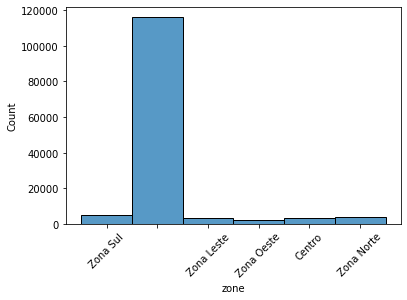

In [33]:
sns.histplot(data=listings_df, x='zone')
plt.xticks(rotation = 45)
plt.show()

Existem muito mais imóveis sem classificação, então é importante encontrar essas zonas

Dentro da feature `locationId` existe a definição da zona do imóvel

## testando a expansão da feature zona pelo locationId

# New Section

In [34]:
listings_df.locationId.isnull().sum()

0

In [35]:
len(listings_df.locationId.unique())

1185

In [36]:
len(listings_df.query("locationId==' '"))

0

Todas a linhas estão preenchidas

In [37]:
listings_df.locationId[0]

'BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da Saude'

In [38]:
if "Centro" in listings_df.locationId[0]:
  print("Centro")
else:
  print

## Adicionando as zonas faltantes

In [39]:
def get_zone(location):
  zonas = ['Zona Sul', 'Zona Leste', 'Zona Oeste', 'Centro', 'Zona Norte']
  found_zone = []
  for zone in zonas:
    if zone in location:
      return zone

In [40]:
found_zone = listings_df.locationId.apply(get_zone)

In [41]:
found_zone

0           Zona Sul
1           Zona Sul
2             Centro
3           Zona Sul
4           Zona Sul
             ...    
133959        Centro
133960    Zona Oeste
133961    Zona Oeste
133962    Zona Oeste
133963        Centro
Name: locationId, Length: 133964, dtype: object

In [42]:
type(found_zone)

pandas.core.series.Series

# Novo DF com `zone`completo

In [43]:
listings_df['zones'] = found_zone

In [44]:
listings_df.head()

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos,country,zipCode,city,streetNumber,zone,geoLocation,street,locationId,district,unitNumber,state,neighborhood,precision,price,businessType,period,yearlyIptu,rentalTotalPrice,monthlyCondoFee,zones
0,388.0,"04 dorms sendo 01 suíte e closet, sala de esta...",PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,2017-02-07T13:21:40Z,f4603b2b52,TWO_STORY_HOUSE,ACTIVE,787c7bd19d,6.0,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04290030', 'city...",1.0,STANDARD,3.0,388.0,4.0,"{'price': 700000, 'businessType': 'SALE'}",BR,04290030,São Paulo,53,Zona Sul,"{'lon': -46.614222, 'lat': -23.612923}",Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,São Paulo,Jardim da Saúde,ROOFTOP,700000,SALE,NaN,NaN,NaN,NaN,Zona Sul
1,129.0,"03 dorms sendo 01 suíte, sala, sala de jantar,...",PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,2016-03-21T18:35:17Z,f4603b2b52,HOME,ACTIVE,4d68c0cdbe,2.0,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04187320', 'city...",1.0,STANDARD,2.0,129.0,3.0,"{'price': 336000, 'businessType': 'SALE'}",BR,04187320,São Paulo,16,Zona Sul,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Juruaba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,,,São Paulo,Vila Santa Teresa (Zona Sul),NaN,336000,SALE,NaN,NaN,NaN,NaN,Zona Sul
2,396.0,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",Excelente Conjunto Comercial na Av. Paulista,2018-12-18T23:47:03.425Z,501f6d5e94,COMMERCIAL_PROPERTY,ACTIVE,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,"{'country': '', 'zipCode': '01311000', 'city':...",0.0,STANDARD,4.0,NaN,0.0,"{'period': 'MONTHLY', 'yearlyIptu': 4040, 'pri...",,01311000,São Paulo,402,,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,São Paulo,Bela Vista,NaN,24929,RENTAL,MONTHLY,4040.0,29829.0,4900.0,Centro
3,80.0,"Viva melhor e de um jeito novo, com privilégio...","Apartamento com 80m², 2 vagas próximo ao Parqu...",2018-10-26T16:18:28.915Z,527c7b0cc0,APARTMENT,ACTIVE,6654d93423,2.0,2018-11-08T16:38:35.434Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '04550004', 'city':...",1.0,STANDARD,2.0,80.0,3.0,"{'yearlyIptu': 1610, 'price': 739643, 'busines...",,04550004,São Paulo,1190,,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Alvorada,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,,,São Paulo,Vila Olímpia,NaN,739643,SALE,NaN,1610.0,NaN,686.0,Zona Sul
4,3322.0,Sua área é ocupada majoritariamente por instit...,"Apartamento 332m², 4 suítes à venda próximo ao...",2018-12-14T18:06:51.342Z,527c7b0cc0,APARTMENT,ACTIVE,9ffaf676ae,5.0,2018-12-14T18:06:55.140Z,False,[https://vr-prod-vivapro-images.s3.amazonaws.c...,"{'country': '', 'zipCode': '04005030', 'city':...",4.0,STANDARD,5.0,332.0,4.0,"{'yearlyIptu': 18900, 'price': 7520099, 'busin...",,04005030,São Paulo,380,,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Curitiba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,,,São Paulo,Paraíso,NaN,7520099,SALE,NaN,18900.0,NaN,6230.0,Zona Sul


Checando a nova distribuição

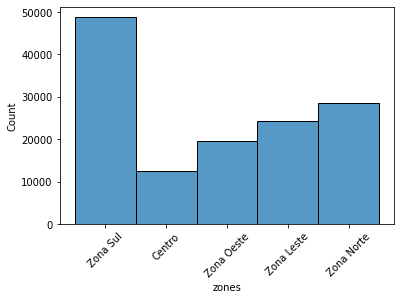

In [56]:
sns.histplot(data=listings_df, x='zones' )
plt.xticks(rotation=45)
plt.show()

POdemos perceber maior disponibilidade de imóveis na Zona Sul. 

In [49]:
zs = len(listings_df.query('zones == "Zona Sul"'))
ct = len(listings_df.query('zones == "Centro"'))
zo = len(listings_df.query('zones == "Zona Oeste"'))
zl = len(listings_df.query('zones == "Zona Leste"'))
zn = len(listings_df.query('zones == "Zona Norte"'))

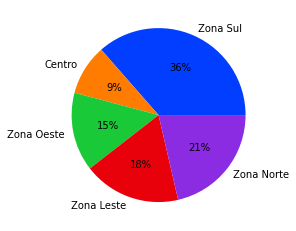

In [50]:
#define data
data = [zs,ct,zo,zl,zn]
labels = ['Zona Sul', 'Centro', 'Zona Oeste', 'Zona Leste', 'Zona Norte']
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

# VALIDANDO HIPOTESE 1: `há maior disponibilidade de imoveis em regioes da zona sul da cidade comparado com outras regioes`

## Sim

Existe maior número de imóveis disponíveis na zona sul de são paulo comparado às demais regiões.  
A região sul representa 36% dos imóveis sendo que a ZN (segundo lugar) representa 21%.  Em números, são 48.810 imóveis na ZS, contra 28.631 na ZN.

In [57]:
zs, zn

(48810, 28631)

# VALIDADANDO HIPÓTESE 2: `regioes mais afastadas do centro Possuem maior disponibilidade ou nao`